## **PCA de l'AMO**


# Récupère les données

In [21]:
# first we have to install some libraries in Colab
!pip install zarr
!pip install gcsfs
!apt-get -qq install python-cartopy python3-cartopy
!pip install sklearn-xarray

# colab requires a specific installation of cartopy
!apt-get -qq install python-cartopy python3-cartopy;
!pip uninstall -y shapely;    # cartopy and shapely don't work well together at the moment...
!pip install shapely --no-binary shapely; # so reinstall a version that will work

Uninstalling Shapely-1.6.4:
  Successfully uninstalled Shapely-1.6.4
     |████████████████████████████████| 389kB 8.3MB/s 
Skipping wheel build for shapely, due to binaries being disabled for it.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
    Running setup.py install for shapely ... done


In [22]:
# general setup
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import gcsfs
from scipy import signal # for periodogram


#from dask_ml.decomposition import PCA
from sklearn.decomposition import PCA
# import the LinearRegression method from scikit-learn
from sklearn.linear_model import LinearRegression

from sklearn.svm import SVR

# set up cartopy
import cartopy.crs as ccrs
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh


# notebook display options
xr.set_options(display_style='html')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [23]:
def load_data(string):
  # and load in the SSH data
  df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
  df_ssh = df.query(string)

  # setup the gcs access
  gcs = gcsfs.GCSFileSystem(token='anon')

  # get the path to a specific zarr store (the first one from the dataframe above)
  zstore = df_ssh.zstore.values[-1]

  # create a mapping interface to the store
  mapper = gcs.get_mapper(zstore)

  # open it using xarray and zarr
  ds = xr.open_zarr(mapper, consolidated=True)
  ds = ds.sel(y=slice(200,310), x=slice(190, 280))
  return ds

In [24]:
def Ano_sst(ds, correct, rollLen):
  tos = ds.tos
  if correct:  
    tos_trend = getTrend(tos)

    tos = tos  - tos_trend # on enleve la tendance

  
  #tos_mean= tos.mean('y').mean('x')
  tos_mean = tos_mean.rolling(time=rollLen  , center=True).mean()#

  return tos_mean

In [25]:
def getTrend(tos):
  # create a generic instance the model
  model = LinearRegression()

  tim = np.arange(0,len(tos.time))
  # fit the model
  # (we have to add [:,None] because the method expects to receive 2D arrays as input data)
  model.fit(tim[:,None], tos.mean('y').mean('x').values[:,None])

  # get the predicted values of ŷ using the model:
  tos_trend = model.predict(tim[:,None])
  tos_trend=xr.DataArray(tos_trend.squeeze(),dims=('time'),coords={'time':tos['time']})
  return tos_trend

In [26]:
ds_ssp126 = load_data("activity_id=='ScenarioMIP' & table_id == 'Omon' & variable_id == 'tos' & experiment_id == 'ssp126' & institution_id == 'IPSL'")


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [27]:
ds_ssp126 


<xarray.Dataset>
Dimensions:         (axis_nbounds: 2, nvertex: 4, time: 1032, x: 90, y: 110)
Coordinates:
    bounds_nav_lat  (y, x, nvertex) float32 dask.array<chunksize=(110, 90, 4), meta=np.ndarray>
    bounds_nav_lon  (y, x, nvertex) float32 dask.array<chunksize=(110, 90, 4), meta=np.ndarray>
    nav_lat         (y, x) float32 dask.array<chunksize=(110, 90), meta=np.ndarray>
    nav_lon         (y, x) float32 dask.array<chunksize=(110, 90), meta=np.ndarray>
  * time            (time) datetime64[ns] 2015-01-16T12:00:00 ... 2100-12-16T12:00:00
    time_bounds     (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(1032, 2), meta=np.ndarray>
Dimensions without coordinates: axis_nbounds, nvertex, x, y
Data variables:
    area            (y, x) float32 dask.array<chunksize=(110, 90), meta=np.ndarray>
    tos             (time, y, x) float32 dask.array<chunksize=(247, 110, 90), meta=np.ndarray>
Attributes:
    CMIP6_CV_version:       cv=6.2.15.1
    Conventions:            CF-1.7 CMIP-6.2
    EXPID:                  ssp126
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  60265.0
    contact:                ipsl-cmip6@listes.ipsl.fr
    creation_date:          2019-09-27T14:25:02Z
    data_specs_version:     01.00.28
    description:            Future scenario with low radiative forcing by the...
    dr2xml_md5sum:          b6f602401512e82e2d7cadc2c6f36c2a
    dr2xml_version:         1.16
    experiment:             update of RCP2.6 based on SSP1
    experiment_id:          ssp126
    external_variables:     areacello
    forcing_index:          1
    frequency:              mon
    further_info_url:       https://furtherinfo.es-doc.org/CMIP6.IPSL.IPSL-CM...
    grid:                   native ocean tri-polar grid with 105 k ocean cells
    grid_label:             gn
    history:                none
    initialization_index:   1
    institution:            Institut Pierre Simon Laplace, Paris 75252, France
    institution_id:         IPSL
    license:                CMIP6 model data produced by IPSL is licensed und...
    mip_era:                CMIP6
    model_version:          6.1.10
    name:                   /ccc/work/cont003/gencmip6/oboucher/IGCM_OUT/IPSL...
    nominal_resolution:     100 km
    parent_activity_id:     CMIP
    parent_experiment_id:   historical
    parent_mip_era:         CMIP6
    parent_source_id:       IPSL-CM6A-LR
    parent_time_units:      days since 1850-01-01 00:00:00
    parent_variant_label:   r6i1p1f1
    physics_index:          1
    product:                model-output
    realization_index:      6
    realm:                  ocean
    source:                 IPSL-CM6A-LR (2017):  atmos: LMDZ (NPv6, N96; 144...
    source_id:              IPSL-CM6A-LR
    source_type:            AOGCM BGC
    status:                 2020-02-24;created; by gcs.cmip6.ldeo@gmail.com
    sub_experiment:         none
    sub_experiment_id:      none
    table_id:               Omon
    title:                  IPSL-CM6A-LR model output prepared for CMIP6 / Sc...
    tracking_id:            hdl:21.14100/aaf72d8a-7a22-41ff-a795-aef14494c523
    variable_id:            tos
    variant_info:           Each member starts from the corresponding member ...
    variant_label:          r6i1p1f1

In [28]:
tos = ds_ssp126.tos
tos_mean = tos.rolling(time=84, center=True).mean()
tos_mean

<xarray.DataArray (time: 1032, y: 110, x: 90)>
dask.array<where, shape=(1032, 110, 90), dtype=float32, chunksize=(247, 110, 90), chunktype=numpy.ndarray>
Coordinates:
    nav_lat  (y, x) float32 dask.array<chunksize=(110, 90), meta=np.ndarray>
    nav_lon  (y, x) float32 dask.array<chunksize=(110, 90), meta=np.ndarray>
  * time     (time) datetime64[ns] 2015-01-16T12:00:00 ... 2100-12-16T12:00:00
Dimensions without coordinates: y, x

/usr/local/lib/python3.6/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/lib/python3/dist-packages/cartopy/io/__init__.py:264: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/110m/physical/ne_110m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


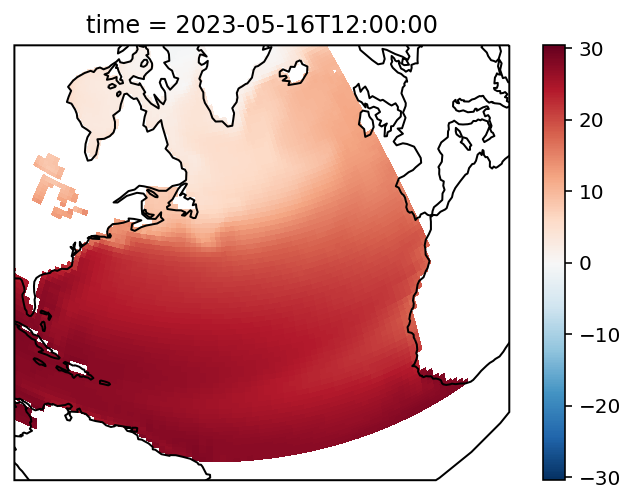

In [31]:
# select the projection that we want
ax = plt.axes(projection=ccrs.Orthographic(-50,55,));
# then we set the latitude limits on our figure
ax.set_extent([-80, 0, 0, 65], ccrs.PlateCarree())
# plot the data using xarray
tos_mean[100].plot.pcolormesh(ax=ax,transform=ccrs.PlateCarree(),x='nav_lon', y='nav_lat', add_colorbar=True); 
# and finally add the coastlines
ax.coastlines();

In [10]:
tos_mean = tos_mean[50:55]
tos_mean

<xarray.DataArray (time: 5, y: 110, x: 90)>
dask.array<getitem, shape=(5, 110, 90), dtype=float32, chunksize=(5, 110, 90), chunktype=numpy.ndarray>
Coordinates:
    nav_lat  (y, x) float32 dask.array<chunksize=(110, 90), meta=np.ndarray>
    nav_lon  (y, x) float32 dask.array<chunksize=(110, 90), meta=np.ndarray>
  * time     (time) datetime64[ns] 2019-03-16T12:00:00 ... 2019-07-16T12:00:00
Dimensions without coordinates: y, x